# Finding Heavy Traffic Indicators on I-94
### By: Raza Saeed

### Purpose
* The purpose of this analysis is to see which factors impact the volume of traffic. These factors could include time of day, day of week, weather patterns and more.

* The dataset documentation mentions that a station located approximately midway between Minneapolis and Saint Paul recorded westbound traffic data on an hourly basis.

### Import Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='white')

# Ignore any warnings
import warnings
warnings.filterwarnings('ignore')

### Load in Dataset

In [2]:
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

# First 5 Rows
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
# Last 5 rows
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


#### Observations
- Each row represents an hour of data collected by the traffic station
- For example the first row represents data for October 12th, 2012 from 9 am to 10 am. During that hour, the temperature was 288 degress kelvin (or 15.13 degress celsius). There was no rain and no snow, but 75% of the sky was covered by clouds. The number of cars that passed the station that hour was 5545.

In [4]:
# How many rows and columns?
traffic.shape

(48204, 9)

In [5]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


#### Observations
- The datset has 48,204 rows and 9 columns
- We'll need to convert the date_time column to the date_time data type

#### Below are the descriptions of each column from the documentation:

* holiday – US National holidays plus a regional holiday (the Minnesota State Fair)
* temp – average temperature in kelvin
* rain_1h – the amount in mm of rain per hour
* snow_1h – the amount in mm of snow per hour
* clouds_all – % of cloud cover
* weather_main – a short text description of the current weather
* weather_description – a longer text description of the current weather
* date_time – the time the data collected in local CST time
* traffic_volume – the number of cars that passed the station each hour

In [6]:
# Statistics for numerical data
traffic.describe().round(2).T.drop(columns=['count'])

,mean,std,min,25%,50%,75%,max
temp,281.21,13.34,0.0,272.16,282.45,291.81,310.07
rain_1h,0.33,44.79,0.0,0.00,0.00,0.00,9831.30
snow_1h,0.00,0.01,0.0,0.00,0.00,0.00,0.51
clouds_all,49.36,39.02,0.0,1.00,64.00,90.00,100.00
traffic_volume,3259.82,1986.86,0.0,1193.00,3380.00,4933.00,7280.00


In [7]:
# Statistics for categorical data
traffic.describe(include=['O']).T.drop(columns=['count'])

,unique,top,freq
holiday,12,None,48143
weather_main,11,Clouds,15164
weather_description,38,sky is clear,11665
date_time,40575,2013-05-19 10:00:00,6


### Traffic Volume

In [8]:
traffic['traffic_volume'].value_counts(bins=10)

(-7.281000000000001, 728.0]    8095
(4368.0, 5096.0]               7886
(5096.0, 5824.0]               5634
(728.0, 1456.0]                5100
(2184.0, 2912.0]               4765
(2912.0, 3640.0]               4761
(3640.0, 4368.0]               4349
(5824.0, 6552.0]               3854
(1456.0, 2184.0]               2835
(6552.0, 7280.0]                925
Name: traffic_volume, dtype: int64

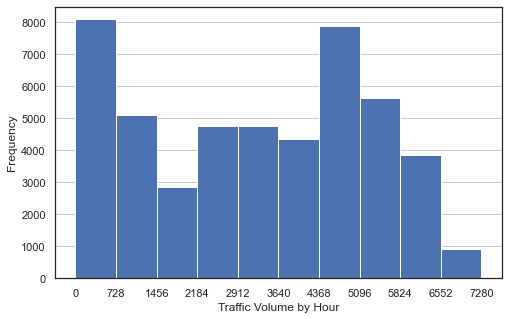

In [9]:
# Plot Traffic Volume
count, bin_edges = np.histogram(traffic['traffic_volume'])

plt.figure(figsize=(8,5))
traffic['traffic_volume'].plot.hist(xticks=bin_edges)
plt.xlabel('Traffic Volume by Hour')
plt.grid(axis='y')
plt.show()

#### Observations
- The most frequent traffic volume range is between 0 and 728 cars with over 8000 occurrences.
- The next most frequent traffic volume range is between 4368 to 5096 cars with just under 8000 occurences.
- The average traffic volume is 3260 cars per hour.
- About 25% of the time, 1193 or fewer cars pass the station each hour.
- About 25% of the time, 4933 or more cars pass the station each hour.

#### Split dataframe into day and night

In [11]:
# Convert to datetime
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

In [12]:
# Day will be between 7 am and 7 pm 
day = traffic[(traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19)]

day.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [13]:
# Night will be between 7 pm and 7 am
night = traffic[(traffic['date_time'].dt.hour < 7) | (traffic['date_time'].dt.hour >= 19)]

night.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
10,None,290.97,0.0,0.0,20,Clouds,few clouds,2012-10-02 19:00:00,3539
11,None,289.38,0.0,0.0,1,Clear,sky is clear,2012-10-02 20:00:00,2784
12,None,288.61,0.0,0.0,1,Clear,sky is clear,2012-10-02 21:00:00,2361
13,None,287.16,0.0,0.0,1,Clear,sky is clear,2012-10-02 22:00:00,1529
14,None,285.45,0.0,0.0,1,Clear,sky is clear,2012-10-02 23:00:00,963


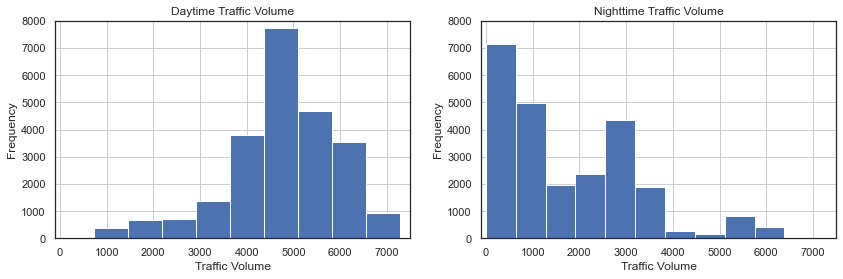

In [14]:
# Plot day and night traffic volume seperately
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.title('Daytime Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.title('Nighttime Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.grid()

plt.show()

In [15]:
# Average Traffic Volume (Daytime vs Nighttime)
print(day['traffic_volume'].mean())
print(night['traffic_volume'].mean())

4762.047451522386
1785.377440703745


In [55]:
day_mean = day['traffic_volume'].mean()
night_mean = night['traffic_volume'].mean()

round(day_mean / night_mean, 2)

2.67

#### Observations
- The average traffic volume during the day is 4762 cars, while the average traffic volume during the night is only 1785 cars.
- The average hourly traffic volume during the day is almost 3000 more cars than during the night. 
- The average hourly traffic volume during the day is 2.67 times more than during the night.

#### I will be using the "day" data to do my analysis due to significant difference in traffic volume.

### Traffic Volume by Month

In [33]:
# Extract Month from date_time column
day['month'] = day['date_time'].dt.month

day.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month,year,dayofweek
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,10,2012,1
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,2012,1
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,10,2012,1
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,10,2012,1
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,10,2012,1


In [59]:
by_month = day.groupby('month').mean()

# Average traffic volume by month
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

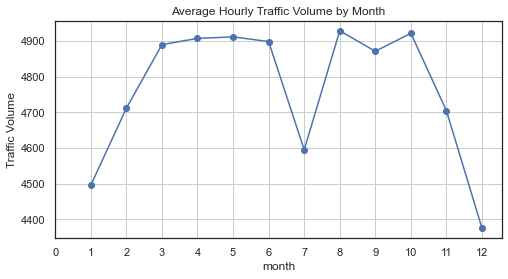

In [19]:
# Plot average traffic volume by month
plt.figure(figsize=(8,4))
by_month['traffic_volume'].plot(marker='o')
plt.xticks(np.arange(0,13,1))
plt.title('Average Hourly Traffic Volume by Month')
plt.ylabel('Traffic Volume')
plt.grid()
plt.show()

#### Obseravation

* There is a steep decline in traffic volume in July, let's find out why.

In [34]:
# Create a year column
day['year'] = day['date_time'].dt.year

In [28]:
# Isolate only for July
only_july = day[day['month'] == 7]

only_july.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month,year
7350,None,289.15,0.0,0.0,75,Clouds,broken clouds,2013-07-01 07:00:00,6783,7,2013
7351,None,291.59,0.0,0.0,1,Clear,sky is clear,2013-07-01 08:00:00,5742,7,2013
7352,None,294.15,0.0,0.0,1,Clear,sky is clear,2013-07-01 09:00:00,4764,7,2013
7353,None,295.60,0.0,0.0,1,Clear,sky is clear,2013-07-01 10:00:00,4669,7,2013
7354,None,297.15,0.0,0.0,1,Clear,sky is clear,2013-07-01 11:00:00,4863,7,2013


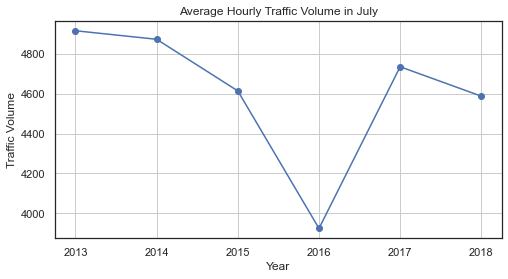

In [27]:
# Plot average July traffic volume by year
plt.figure(figsize=(8,4))
only_july.groupby('year').mean()['traffic_volume'].plot.line(marker='o')
plt.title('Average Hourly Traffic Volume in July')
plt.xlabel('Year')
plt.ylabel('Traffic Volume')
plt.grid()
plt.show()

#### Observations
- Seems like there was a big drop in traffic in July of 2016. This could have be due to construction.
- There is a sharp increase in traffic volume from months 1 to 3 as the weather gets warmer.
- Average traffic volume stays relatively constant from months 3-10 with the exception of month 7 which we already stated why.
- There is a sharp decline in months 11 and 12 as the weather starts to get cold again.

### Traffic Volume by Day of Week

In [35]:
# Create a day of week column
day['dayofweek'] = day['date_time'].dt.dayofweek

day.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,month,year,dayofweek
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,10,2012,1
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,2012,1
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,10,2012,1
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,10,2012,1
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,10,2012,1


#### Notes
* '0' is Monday and '6' is Sunday

In [36]:
by_dayofweek = day.groupby('dayofweek').mean()

# Average traffic volume by day of week
by_dayofweek['traffic_volume']

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

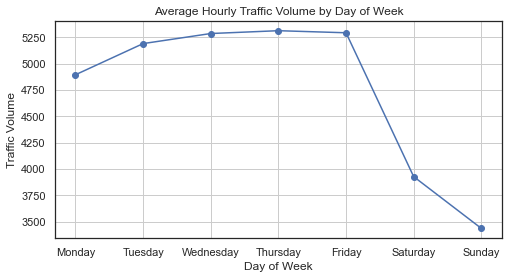

In [37]:
# Plot average traffic volume by day of week
plt.figure(figsize=(8,4))
by_dayofweek['traffic_volume'].plot(marker='o')
plt.title('Average Hourly Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel('Traffic Volume')
plt.grid()
plt.show()

#### Observations
- The average hourly traffic increases steadily between Monday to Thursday and drops off slightly on Friday.
- There is a steep drop off in traffic volume on Saturday's and Sundays.

### Traffic Volume by Hour

In [38]:
# Create an hour column
day['hour'] = day['date_time'].dt.hour

In [39]:
# Create a seperate dataframe for Business Days
business_days = day[day['dayofweek'] <=4]

# Create a seperate dataframe for the Weekend
weekend = day[day['dayofweek'] >=5]

In [40]:
by_hour_business = business_days.groupby('hour').mean()

# Hourly daytime traffic volume on businss days
by_hour_business['traffic_volume']

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64

In [41]:
by_hour_weekend = weekend.groupby('hour').mean()

# Hourly daytime traffic volume on weekends
by_hour_weekend['traffic_volume']

hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64

#### Observations
- The busiest hour of traffic during the day on the weekend is still less busy then the least busiest hour of traffic during the weekday. 
- The busiest hour of traffic on the weekend is between 12 and 1 pm with an average of 4372 cars.
- The slowest hour of traffic on busiess days is between 10 and 11 am with an average of 4378 cars.

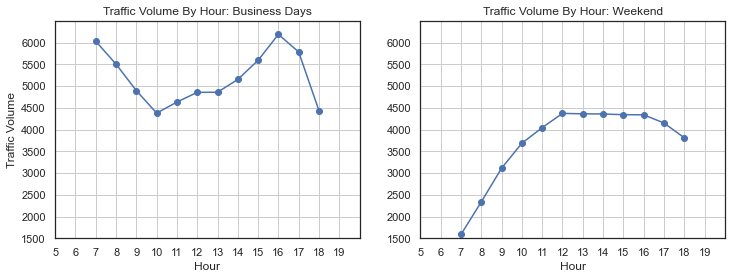

In [62]:
# Plot hourly business day data and weekend data side by side
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot.line(marker='o')
plt.xlabel('Hour')
plt.xlim(6,20)
plt.xticks(np.arange(5,20,1))
plt.ylabel('Traffic Volume')
plt.ylim(1500,6500)
plt.yticks(np.arange(1500, 6500, 500))
plt.title('Traffic Volume By Hour: Business Days')
plt.grid()

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot.line(marker='o')
plt.xlabel('Hour')
plt.xlim(6,20)
plt.xticks(np.arange(5,20,1))
plt.ylim(1500,6500)
plt.yticks(np.arange(1500, 6500, 500))
plt.title('Traffic Volume By Hour: Weekend')
plt.grid()

plt.show()

### Observations
#### Business Days
- The busiest hours of traffic on business days is between 7 and 8 am and between 4 and 5 pm which correspond to rush hours
- Traffic volume decreases from 7 to 11 am
- Traffic volume increases from 11 am to 5 pm where it reaches it's peak
- Traffic volume decreases after 5 pm

#### Weekend
- Traffic volume on weekends is much lower than on business days
- Traffic volume increases steadily each hour from 7 am to 12 pm where it reaches its peak
- Traffic volume stays relatively consistent after 12 pm until 5 pm where it starts to drop again
- The busiest hour of traffic on weekends is still less busy compared to the least busy hour on business days

### Correlation of weather and traffic volume

In [43]:
# Correlation of rain, snow and cloud coverage on traffic volume
day.corr()['traffic_volume'].drop(['traffic_volume', 'hour', 'month', 'dayofweek']).sort_values(ascending=False)

temp          0.128317
rain_1h       0.003697
snow_1h       0.001265
year         -0.003557
clouds_all   -0.032932
Name: traffic_volume, dtype: float64

#### Observations
- No strong correlations between different weather types and traffic volume
- Strongest correlation is with tempearture at only 0.13


In [45]:
# Convert temperature from kelvin to celsius
day['temp'] = day['temp'] - 273.15

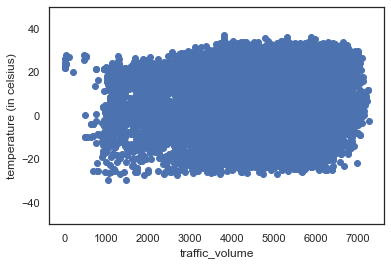

In [46]:
# Plot traffic volume against temperature
plt.scatter(x=day['traffic_volume'], y=day['temp'])
plt.xlabel('traffic_volume')
plt.ylabel('temperature (in celsius)')
plt.ylim(-50, 50)
plt.show()

#### Observations
- Temperature is not a strong predictor of traffic volume

### Categorical Weather Data
Are there any weather types which lead to higher or lower traffic volume?

#### By Weather Type

In [48]:
# How many occurenes of each weather type?
day['weather_main'].value_counts()

Clouds          8702
Clear           5744
Rain            2841
Mist            2593
Snow            1454
Drizzle          883
Haze             834
Thunderstorm     451
Fog              362
Smoke             12
Squall             1
Name: weather_main, dtype: int64

In [47]:
by_weather_main = day.groupby('weather_main').mean()

# Average traffic volume by weather type
by_weather_main['traffic_volume'].sort_values(ascending=False)

weather_main
Clouds          4865.415996
Drizzle         4837.212911
Rain            4815.568462
Clear           4778.416260
Thunderstorm    4648.212860
Mist            4623.976475
Haze            4609.893285
Smoke           4564.583333
Snow            4396.321183
Fog             4372.491713
Squall          4211.000000
Name: traffic_volume, dtype: float64

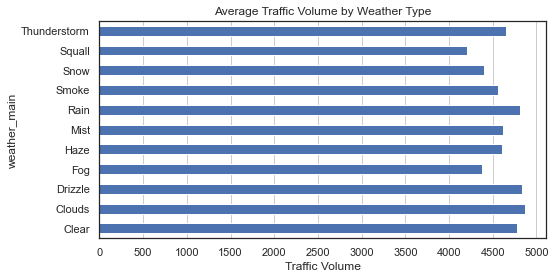

In [49]:
# Plot average traffic volume by weather type
plt.figure(figsize=(8,4))
by_weather_main['traffic_volume'].plot(kind='barh')
plt.title('Average Traffic Volume by Weather Type')
plt.xlabel('Traffic Volume')
plt.xticks(np.arange(0, 5500, 500))
plt.grid(axis='x')
plt.show()

#### Observations 
- Clear skies, cloudy, drizzle and rain tend to have higher traffic volume
- More significant weather like squall, fog and snow tend to reduce the traffic volume

#### By Weather Description

In [50]:
# Rename some weather descriptions
day['weather_description'] = day['weather_description'].replace(['Sky is Clear', 'sky is clear'], 'sky is clear').replace('SQUALLS', 'squall')

In [52]:
# How many occurences of each weather description?
day['weather_description'].value_counts()

sky is clear                           5744
broken clouds                          2793
mist                                   2593
overcast clouds                        2585
scattered clouds                       2181
light rain                             1707
few clouds                             1143
light snow                              978
haze                                    834
moderate rain                           785
light intensity drizzle                 573
fog                                     362
heavy snow                              320
proximity thunderstorm                  303
drizzle                                 278
heavy intensity rain                    219
snow                                    137
proximity shower rain                   111
thunderstorm                             48
heavy intensity drizzle                  29
thunderstorm with heavy rain             25
thunderstorm with light rain             23
thunderstorm with rain          

In [53]:
by_weather_description = day.groupby('weather_description').mean()

# Average traffic volume by weather description
by_weather_description['traffic_volume'].sort_values(ascending=False)

weather_description
shower snow                            5664.000000
light rain and snow                    5579.750000
proximity thunderstorm with drizzle    5121.833333
thunderstorm with light drizzle        4960.000000
scattered clouds                       4936.787712
shower drizzle                         4932.666667
proximity shower rain                  4901.756757
light intensity drizzle                4890.164049
overcast clouds                        4861.124952
light rain                             4859.650849
few clouds                             4839.818023
broken clouds                          4824.130326
very heavy rain                        4780.571429
sky is clear                           4778.416260
moderate rain                          4769.643312
heavy intensity drizzle                4738.586207
drizzle                                4737.330935
thunderstorm                           4724.708333
proximity thunderstorm                 4684.356436
mist       

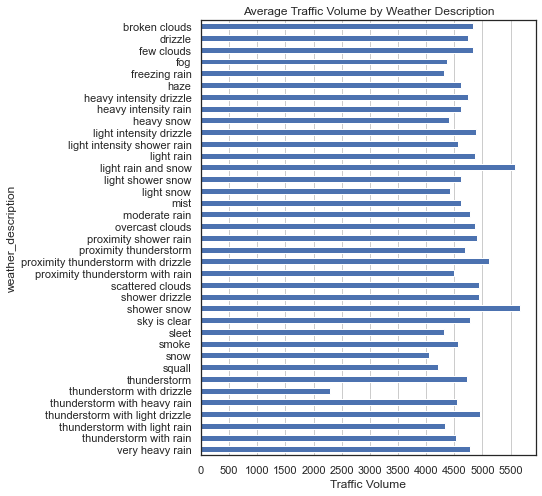

In [54]:
# Plot average traffic volume by weather description
plt.figure(figsize=(6,8))
by_weather_description['traffic_volume'].sort_index(ascending=False).plot(kind='barh')
plt.title('Average Traffic Volume by Weather Description')
plt.xlabel('Traffic Volume')
plt.xticks(np.arange(0, 6000, 500))
plt.grid(axis='x')
plt.show()

#### Observations
- "Shower Snow" only had 1 occurence while "Light Rain and Snow" only had 4 occurences so it is hard to say definitely that when these weather patterns occur, traffic volume increases. A larger sample size is required.

## Conclusion

* Traffic Volume is higher on business days compared to weekends
* Traffic Volume is higher during the days compared to nights
* Traffic Volume peaks during rush hours
* Traffic Volume is higher in the warmer months compared to the colder months
* Traffic Volume is generally higher with less inclement weather (like cloudy or rainy) compared to more inclement weather (like snow or fog)